In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

# Ignore Harmless Warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Implementation of the ResNet-50 Architecture

class ResidualBlock(torch.nn.Module):
    

    def __init__(self, in_channels, out_channels, downsample = None, stride = 1):
        
        super(ResidualBlock, self).__init__()

        self.expansion = 4
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = 1, padding = 0)
        self.BatchNorm1 = torch.nn.BatchNorm2d(out_channels)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = stride, padding = 1)
        self.BatchNorm2 = torch.nn.BatchNorm2d(out_channels)
        self.conv3 = torch.nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size = 1, stride = 1, padding = 0)
        self.BatchNorm3 = torch.nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = torch.nn.ReLU()
        self.downsample = downsample
  
    def forward(self, x):
        
        identity = x

        x = self.conv1(x)
        x = self.BatchNorm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.BatchNorm2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.BatchNorm3(x)

    # After Each Block we will add the identity 
    # Change the shape in some way so that the input and the output have the same shape for successful addition

        if self.downsample is not None:
            
            identity = self.downsample(identity)
    
            x += identity
        x = self.relu(x)

        return x

class ResNet(torch.nn.Module):
    
    def __init__(self, residual_block, layers, image_channels, num_classes = 10):
        
        super(ResNet, self).__init__()
        self.in_channels = 64
        # The initial layer(Not the Resnet Layer)
        self.conv1 = torch.nn.Conv2d(image_channels, 64, kernel_size = 7, stride = 2, padding = 3)
        self.BatchNorm1 = torch.nn.BatchNorm2d(64)
        self.relu = torch.nn.ReLU()
        self.maxpool = torch.nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        # Defining the ResNet Layers
        self.layer1 = self.make_layer(residual_block, layers[0], out_channels = 64, stride = 1) # In the end it will be 64*4
        self.layer2 = self.make_layer(residual_block, layers[1], out_channels = 128, stride = 2) # In the end it will be 128*4
        self.layer3 = self.make_layer(residual_block, layers[2], out_channels = 256, stride = 2) # In the end it will be 256*4
        self.layer4 = self.make_layer(residual_block, layers[3], out_channels = 512, stride = 2) # In the end it will be 512*4

        # Average Pooling
        self.avg_pool = torch.nn.AdaptiveAvgPool2d((1,1))
    
        # Fully Connected Layers
        self.fc = torch.nn.Linear(512*4, num_classes)

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.BatchNorm1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avg_pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return torch.nn.functional.log_softmax(x)
    
  # A helper function to build the ResNet Layer
    def make_layer(self, residual_block, num_residual_block, out_channels, stride):
        
        downsample = None
        layers = []

        if stride != 1 or self.in_channels != out_channels * 4:
            
            downsample = torch.nn.Sequential(torch.nn.Conv2d(self.in_channels, out_channels * 4, kernel_size = 1, stride = stride),
                                       torch.nn.BatchNorm2d(out_channels*4))
    
            layers.append(ResidualBlock(self.in_channels, out_channels, downsample, stride))

            self.in_channels = out_channels * 4 # 256 = 64 * 4
        
        # We are using -1 because the first block is the convolutional block
        for i in range(num_residual_block - 1):
            
            layers.append(ResidualBlock(self.in_channels, out_channels)) # 256->64, 64->(256)
        
        return torch.nn.Sequential(*layers) # Will Unpack the list
    
def ResNet50(img_channels = 3, num_classes = 1000): 
    return ResNet(ResidualBlock, [3,4,6,3], img_channels, num_classes)

In [3]:
# Data Augmentation

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(), # After converting to PyTorch tensor the [0,255] range is converted to [0,1] range
    transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225]) # Mean and Standard deviation for each colour channel
])

# In the test set transformation we dont need to perform random rotation or random horizontal flips

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])
])

root = 'C:\\Users\\shant\\CATS_DOGS\\CATS_DOGS'

# Location of the training data
train_data = datasets.ImageFolder(os.path.join(root,'train'), transform = train_transform)

# Location of the testing data
test_data = datasets.ImageFolder(os.path.join(root,'test'), transform = test_transform)

# Set seed
torch.manual_seed(42)

train_loader = DataLoader(train_data,batch_size=10,shuffle=True)
test_loader = DataLoader(test_data,batch_size=10)

class_names = train_data.classes

# Setup the Loss and the Optimization Parameters
torch.manual_seed(101)

# create device variable
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Object for the ResNet class
resnet = ResNet50(img_channels = 3, num_classes = 2) 

resnet.to(device)

# Loss function
criterion = torch.nn.CrossEntropyLoss()

# The optimizer. We use Adam Optimizer
optimizer = torch.optim.Adam(resnet.parameters(),lr=0.01)

In [4]:
import time 

# The start time of execution
start_time = time.time()

epochs = 3

max_train_batch = 1000 # Batch of 10 images --> 10000 Images
max_test_batch = 500 # Batch of 10 images --> 5000 Images

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    
    trn_corr = 0
    tst_corr = 0

    for b, (x_train, y_train) in enumerate(train_loader):
        
        x_train = x_train.cuda()
        y_train = y_train.cuda()

        # Limit the number of batches
        if b == max_train_batch:
            break
        b += 1
        
        y_pred = resnet(x_train)
        loss = criterion(y_pred,y_train)
        
        # Tally number of correct predictions
        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update the Parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/10000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            X_test = X_test.cuda()
            y_test = y_test.cuda()
            
            # Limit the number of batches
            if b == max_test_batch:
                break

            # Apply the model
            y_val = resnet(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

total_time = time.time() - start_time
print(f'Total Time: {total_time/60} minutes')

epoch:  0  batch:  200 [  2000/10000]  loss: 0.76427305  accuracy:  52.250%
epoch:  0  batch:  400 [  4000/10000]  loss: 0.69543660  accuracy:  51.850%
epoch:  0  batch:  600 [  6000/10000]  loss: 0.68827331  accuracy:  50.700%
epoch:  0  batch:  800 [  8000/10000]  loss: 0.69121677  accuracy:  50.650%
epoch:  0  batch: 1000 [ 10000/10000]  loss: 0.69928056  accuracy:  50.360%
epoch:  1  batch:  200 [  2000/10000]  loss: 0.71251363  accuracy:  50.850%
epoch:  1  batch:  400 [  4000/10000]  loss: 0.66351640  accuracy:  50.575%
epoch:  1  batch:  600 [  6000/10000]  loss: 0.70927209  accuracy:  50.167%
epoch:  1  batch:  800 [  8000/10000]  loss: 0.66756183  accuracy:  49.725%
epoch:  1  batch: 1000 [ 10000/10000]  loss: 0.71283406  accuracy:  49.760%
epoch:  2  batch:  200 [  2000/10000]  loss: 0.71264684  accuracy:  51.350%
epoch:  2  batch:  400 [  4000/10000]  loss: 0.70736897  accuracy:  51.125%
epoch:  2  batch:  600 [  6000/10000]  loss: 0.65681231  accuracy:  51.067%
epoch:  2  b

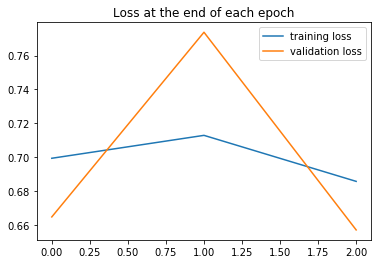

In [5]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();